Importing Libraries:

In [1]:
import csv
import numpy as np
import pandas as pd
import random
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score, roc_auc_score, precision_recall_curve, confusion_matrix
from xgboost import XGBClassifier
import xgboost
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier as MLP

Loading Data:

In [2]:
p = 0.85 # read only 100p% of the lines

df_tr_train = pd.read_csv(
    'train_transaction.csv',
    header=0,
    index_col='TransactionID',
    skiprows=lambda r: r>0 and random.random() > p)

df_id_train = pd.read_csv(
    'train_identity.csv',
    header=0,
    index_col='TransactionID',
    skiprows=lambda r: r>0 and random.random() > p)

Loading Feature List:

In [3]:
def read_csv_file(file_path):
    data = []
    with open(file_path, 'r') as csv_file:
        csv_reader = csv.reader(csv_file)
        for row in csv_reader:
            data.append(row)
    return data[0]

columns_tr = read_csv_file('columns_tr.csv')
columns_id = read_csv_file('columns_id.csv')
columns_categorical_tr = read_csv_file('columns_categorical_tr.csv')
columns_categorical_id = read_csv_file('columns_categorical_id.csv')
columns_non_categorical_tr = [x for x in columns_tr if x not in columns_categorical_tr]
columns_non_categorical_id = [x for x in columns_id if x not in columns_categorical_id]
columns_categorical = columns_categorical_tr + columns_categorical_id
columns_non_categorical = columns_non_categorical_tr + columns_non_categorical_id

Data Cleansing and Preparation:

In [4]:
for column in df_tr_train.columns:
    m = df_tr_train[column].isna()
    if any(m):
        df_tr_train.loc[m,column] = np.random.choice(df_tr_train.loc[~m,column], m.sum())
    
for column in df_id_train.columns:
    m = df_id_train[column].isna()
    if any(m):
        df_id_train.loc[m,column] = np.random.choice(df_id_train.loc[~m,column], m.sum())

In [5]:
df_tr_train = df_tr_train.merge(df_id_train, how='inner', right_index=True, left_index=True)

In [6]:
X_train, X_val, y_train, y_val = train_test_split(df_tr_train.iloc[:,1:], df_tr_train.iloc[:,0], test_size=0.33)

Encoding Categorical Data:

In [7]:
enc = OneHotEncoder(handle_unknown='ignore')
enc_df = enc.fit_transform(X_train[columns_categorical]).toarray()
enc_df = pd.DataFrame(enc_df, columns=enc.get_feature_names_out(columns_categorical), index=X_train.index.values)
X_train = pd.concat([X_train[columns_non_categorical], enc_df], axis=1)

enc_df = enc.transform(X_val[columns_categorical]).toarray()
enc_df = pd.DataFrame(enc_df, columns=enc.get_feature_names_out(columns_categorical), index=X_val.index.values)
X_val = pd.concat([X_val[columns_non_categorical], enc_df], axis=1)

Normalizing Non-Categorical Data:

In [8]:
scaler = MinMaxScaler()
X_train_scaled = X_train.copy()
X_val_scaled = X_val.copy()
X_train_scaled[columns_non_categorical] = scaler.fit_transform(X_train_scaled[columns_non_categorical])
X_val_scaled[columns_non_categorical] = scaler.transform(X_val_scaled[columns_non_categorical])

In [9]:
X_train.head()

,TransactionDT,TransactionAmt,dist1,dist2,C1,C2,C3,C4,C5,C6,...,id_34_match_status:1,id_34_match_status:2,id_35_F,id_35_T,id_36_F,id_36_T,id_37_F,id_37_T,id_38_F,id_38_T
3032187,1094386,25.000,1.0,7.0,1.0,1.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0
3073247,1816063,8.000,0.0,174.0,3.0,2.0,0.0,2.0,0.0,0.0,...,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0
3232011,5839608,36.252,14.0,810.0,1.0,3.0,0.0,3.0,0.0,3.0,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
3514872,13889689,100.000,23.0,646.0,1.0,1.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0
3100760,2218224,50.000,20.0,7.0,2.0,1.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0


In [10]:
X_train_scaled.head()

,TransactionDT,TransactionAmt,dist1,dist2,C1,C2,C3,C4,C5,C6,...,id_34_match_status:1,id_34_match_status:2,id_35_F,id_35_T,id_36_F,id_36_T,id_37_F,id_37_T,id_38_F,id_38_T
3032187,0.064097,0.015956,0.000124,0.000602,0.000214,0.000176,0.0,0.000445,0.0,0.000445,...,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0
3073247,0.109992,0.004987,0.000000,0.014970,0.000641,0.000351,0.0,0.000889,0.0,0.000000,...,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0
3232011,0.365871,0.023217,0.001732,0.069689,0.000214,0.000527,0.0,0.001334,0.0,0.001334,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
3514872,0.877819,0.064352,0.002846,0.055579,0.000214,0.000176,0.0,0.000445,0.0,0.000445,...,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0
3100760,0.135567,0.032088,0.002475,0.000602,0.000427,0.000176,0.0,0.000445,0.0,0.000445,...,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0


Model Training:

In [11]:
xgb = XGBClassifier().fit(X_train, y_train) #XGBoost Classifier
#param_grid = {'n_estimators': [100, 500],
#              'max_depth': [3, 5],
#              'learning_rate': [0.1, 0.1, 0.01]}
  
#xgb_best = GridSearchCV(xgb, param_grid, scoring='precision')
#xgb_best.fit(X_train_cat, y_train)

In [12]:
y_xgb = xgb.predict(X_val)

In [114]:
#svc = SVC(kernel = 'rbf') # Support Vector Machine Classifier

#param_grid = {'C': [0.1, 1, 10], 
#              'gamma': [1, 0.1, 0.01]}
#svc_best = GridSearchCV(svc, param_grid, scoring='precision')
#svc_best.fit(X_train_scaled, y_train)

#y_svc = svc.predict(X_val_scaled)

In [113]:
#mlp = MLPClassifier(hidden_layer_sizes=(50,50,20), activation='relu', solver='adam',
#                    alpha=0.0001, learning_rate='adaptive', learning_rate_init=0.01,
#                    power_t=0.5, max_iter=500) # Multi-Layer Perceptron Classifier

#mlp.fit(X_train_scaled, y_train)
#y_mpl = mlp.predict(X_val_scaled)

Analysis of the results:

In [13]:
x_xgb = xgb.predict(X_train)
score1t = precision_score(y_train, x_xgb)
score2t = recall_score(y_train, x_xgb)
score3t = f1_score(y_train, x_xgb)
score4t = accuracy_score(y_train, x_xgb)
score5t = roc_auc_score(y_train, x_xgb)
print('Train Results:')
print('XGB train precision: ', round(score1t,3))
print('XGB train recall: ', round(score2t,3))
print('XGB train f1: ', round(score3t,3))
print('XGB train accuracy: ', round(score4t,3))
print('XGB train roc auc: ', round(score5t,3))

score1 = precision_score(y_val, y_xgb)
score2 = recall_score(y_val, y_xgb)
score3 = f1_score(y_val, y_xgb)
score4 = accuracy_score(y_val, y_xgb)
score5 = roc_auc_score(y_val, y_xgb)
print('\nTest Results:')
print('XGB test precision: ', round(score1,3))
print('XGB test recall: ', round(score2,3))
print('XGB test f1: ', round(score3,3))
print('XGB test accuracy: ', round(score4,3))
print('XGB test roc auc: ', round(score5,3))

Train Results:
XGB train precision:  0.975
XGB train recall:  0.805
XGB train f1:  0.882
XGB train accuracy:  0.983
XGB train roc auc:  0.902

Test Results:
XGB test precision:  0.906
XGB test recall:  0.677
XGB test f1:  0.775
XGB test accuracy:  0.969
XGB test roc auc:  0.835


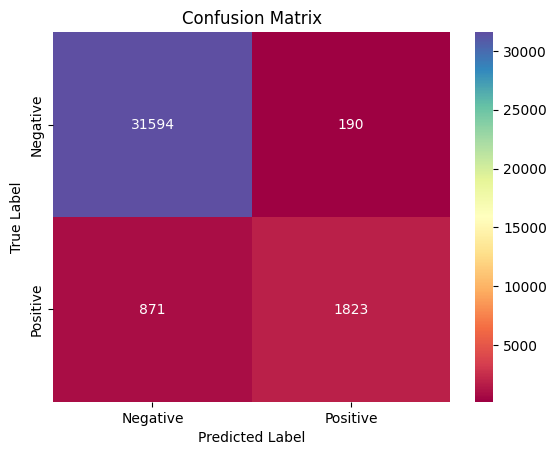

In [14]:
cm = confusion_matrix(y_val, y_xgb)

labels = ['Negative', 'Positive']
plt.figure()
sns.heatmap(cm, annot=True, cmap='Spectral', fmt='d', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

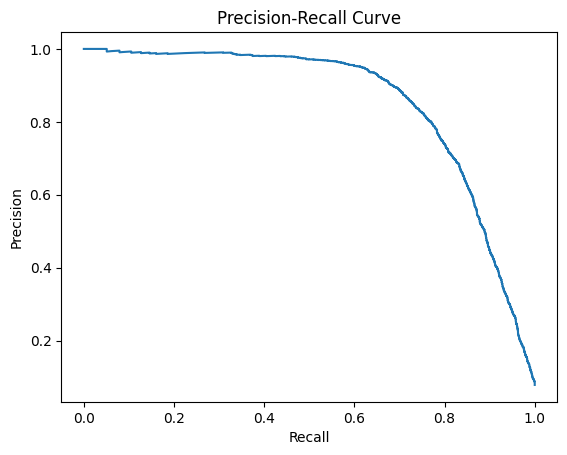

In [15]:
precision, recall, thresholds = precision_recall_curve(y_val, xgb.predict_proba(X_val)[:,1])
plt.figure()
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

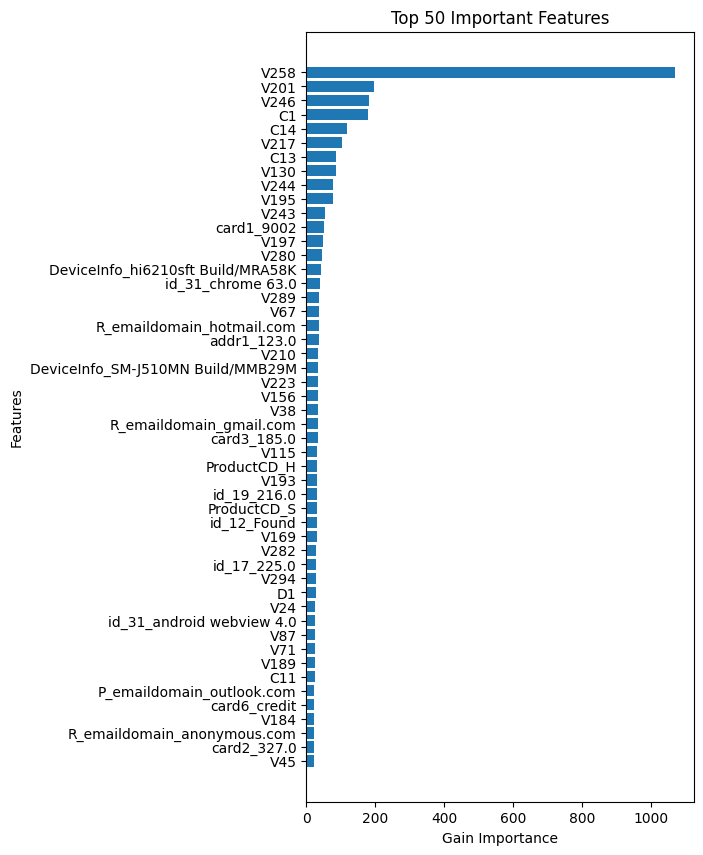

In [18]:
feature_importance = xgb.get_booster().get_score(importance_type='gain')
keys = list(feature_importance.keys())
values = list(feature_importance.values())
data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False).iloc[0:50]
data = data.sort_values(by = "score", ascending=True)
plt.figure(figsize = (5,10));
plt.barh(data.index, data['score']);
plt.xlabel('Gain Importance');
plt.ylabel('Features');
plt.title('Top 50 Important Features');
plt.show()

Test Data Predictions:

In [19]:
df_tr_test = pd.read_csv(
    'test_transaction.csv',
    header=0,
    index_col='TransactionID',
    skiprows=lambda r: r>0 and random.random() > p)

df_id_test = pd.read_csv(
    'test_identity.csv',
    header=0,
    index_col='TransactionID',
    skiprows=lambda r: r>0 and random.random() > p)

for column in df_tr_test.columns:
    m = df_tr_test[column].isna()
    if any(m):
        df_tr_test.loc[m,column] = np.random.choice(df_tr_test.loc[~m,column], m.sum())
    
for column in df_id_test.columns:
    m = df_id_test[column].isna()
    if any(m):
        df_id_test.loc[m,column] = np.random.choice(df_id_test.loc[~m,column], m.sum())
    
df_tr_test = df_tr_test.merge(df_id_test, how='inner', right_index=True, left_index=True)

enc_df = enc.transform(df_tr_test[columns_categorical]).toarray()
enc_df = pd.DataFrame(enc_df, columns=enc.get_feature_names_out(columns_categorical), index=df_tr_test.index.values)
df_tr_test = pd.concat([df_tr_test[columns_non_categorical], enc_df], axis=1)

y_pred = xgb.predict(df_tr_test)

In [24]:
print(y_pred)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 1 1 0 1 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 1 0 0 0 0 0
 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 1 1 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1
 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0
 1 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 1 1 0 1 1 0 0 0 0 1 0 0 